# Dog Breed Classification

> This project is part of the Udacity Nanodegree Program "Data Scientist". 

## Table of Content

* [Project Overview](#Chap0)
* [Import Datasets](#Chap1): Import Datasets
* [Detect Humans](#Chap2): Detect Humans
* [Step 2](#step2): Detect Dogs

* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

In [114]:
import numpy as np
from glob import glob
import os
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

#from sklearn.datasets import load_files 

import torch
#from torch.utils.data import Dataset
#from torchvision.io import read_image
from torch.utils.data import DataLoader
#from torch.nn.functional import interpolate

from source.functions import CustomImageDataset, initialize_model, augment_image


# TODO --> REMOVE
# Force reload
import importlib

In [115]:
# TODO --> REMOVE

# Force reload
import source
importlib.reload(source.functions)
from source.functions import CustomImageDataset, Evaluater
from source.functions import initialize_model, get_device, train_model, print_loss, print_eval

## Project Overview

The goal is to classify images of dogs according to their breed.  

This notebook serves as a preparation towards developing an algorithm that is used as part of a mobile or web app. The developed code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.

In this real-world setting, a series of models to perform different tasks are pieced together:  for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

Some additional resources that might be useful to understand the code are the following:  
* [PIL -- Python Image Library](https://pillow.readthedocs.io/en/stable/handbook/tutorial.html#using-the-image-class)
* [Pytorch Dataloader Intro](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


## Inspect the dataset

Let us get a first intuition of the dataset. How many train/test/validation images do we have? How many classes? How is the distribution of the classes along the training dataset?  
These are all important questions that should be mentioned before training. if there are too less training images, we need more (or use data augmentation). If the classes are unequally distributed, one need to consider this during training, e.g.,  using class weights. 

First of all, load and inspect the datasets.

In [116]:
# Load dataset
train_dataset = CustomImageDataset(os.getcwd() + '/data/dogImages/train', augment = augment_image(augment_prop = 0.3))
test_dataset = CustomImageDataset(os.getcwd() + '/data/dogImages/test')
val_dataset = CustomImageDataset(os.getcwd() + '/data/dogImages/valid')
# 
# Get class names and ids
class_ids, class_names = train_dataset.get_classes()
# 
# Get label informations
train_label_indices, train_label_ids, train_label_names = train_dataset.get_labels()
test_label_indices, test_label_ids, test_label_names = test_dataset.get_labels()
val_label_indices, val_label_ids, val_label_names = val_dataset.get_labels()

Let us first check consistency of the datasets. It would be a problem, if some classes are not represented in the test or validation dataset. 

In [117]:
label_names_unique = np.unique(np.sort(train_label_names))
assert (label_names_unique == np.unique(np.sort(test_label_names))).all()
assert (label_names_unique == np.unique(np.sort(val_label_names))).all()
#
test_class_ids, test_class_names = test_dataset.get_classes()
val_class_ids, val_class_names = val_dataset.get_classes()
assert (test_class_ids == class_ids).all()
assert (val_class_ids == class_ids).all()
assert (test_class_names == class_names).all()
assert (val_class_names == class_names).all()

Display a sample to get an idea how the images look like. Let us use a dataloader for this.

... soooo cute dogs <3

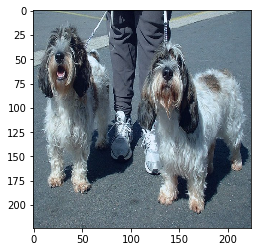

Image shape: torch.Size([3, 3, 224, 224])
Label index: 118
Label id: 119
Label name: Petit_basset_griffon_vendeen
Filepath: h:\work\repositories\LOCAL_Dog_Breed_Classification/data/dogImages/train\119.Petit_basset_griffon_vendeen\Petit_basset_griffon_vendeen_07712.jpg


In [118]:
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)
# 
# Display image and label.
image, idx = next(iter(train_dataloader))
# 
label_index, label_id, label_name = train_dataloader.dataset.get_labels()
file_path = train_dataloader.dataset.get_file_path()
# 
# Prepare for display, plt.imshow requires HWC format...
# Just show the first image...
idx = idx[0]
img = image[0].squeeze()
img = img.permute(1,2,0)
# The images from the dataloader are likely not to be in range [0, 1]
img = (img - img.min())/(img.max() - img.min())
plt.imshow(img)
plt.show()
print(f"Image shape: {image.size()}")
print(f"Label index: {label_index[idx]}")
print(f"Label id: {label_id[idx]}")
print(f"Label name: {label_name[idx]}")
print(f"Filepath: {file_path[idx]}")

Print some initial and basic statistics.

In [119]:
# print statistics about the dataset
print('There are %d total dog categories.' % len(class_names))
print('There are %s total dog images.\n' % (len(train_label_ids) + len(test_label_ids) + len(val_label_ids)))
print('There are %d training dog images.' % len(train_label_ids))
print('There are %d validation dog images.' % len(val_label_ids))
print('There are %d test dog images.'% len(test_label_ids))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


Get class distribution for the training dataset.

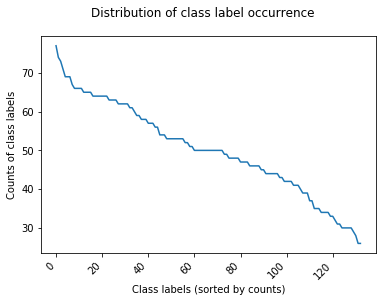

In [120]:
# Use a pandas Dataframe to do the sorting
#df_train = pd.DataFrame({'ids': train_label_ids, 'names': train_label_names})
#class_counts = df_train.groupby('ids').count()['names'].sort_values(ascending=False)
#train_label_names_sorted = np.array(class_counts.index)
#train_label_names_counts = np.array(class_counts.values)

df_train = pd.DataFrame({'index': train_label_indices, 'ids': train_label_ids, 'names': train_label_names})
class_counts = df_train.groupby(['index', 'names']).count().sort_values(by = 'ids', ascending=False)
train_label_names_counts = class_counts.ids.values
train_label_indices_sorted = [item[0] for item in class_counts.ids.index]
train_label_names_sorted = [item[1] for item in class_counts.ids.index]

# Plot the distribution
if (len(train_label_names_sorted) > 30):
    # Use a graph since too many bars cannot be displayed nicely
    plt.plot(np.arange(len(train_label_names_sorted)), train_label_names_counts)
else:
    plt.bar(x = train_label_names_sorted, height = train_label_names_counts)
    
plt.xlabel('Class labels (sorted by counts)')
plt.ylabel('Counts of class labels')
plt.xticks(rotation=45, ha='right')
plt.suptitle('Distribution of class label occurrence')
plt.show()

## Caching and preprocessing the data

As seen above, there are a LOT of images. Therefore, it makes sense to think about how to deal with the data during training.   
Without any caching or preprocessing, the dataloader would read-in and transform the images for each epoch again and again, even if the information could already be present after the first epoch.

To avoid this overhead, a caching mechanism is implemented. Note that this only works if a single worker is used, because no shared memory is used.  
However, the cached data (holding the preprocessed images) can also be written to file and reloaded later. This might be useful if  many experiments are done on the same dataset. 

### Benchmark caching for dataloaders

We will use the validation dataset to show the benefit of caching the data. 

In [28]:
import time

Run with caching

In [35]:
tmp_dataset = CustomImageDataset(os.getcwd() + '/data/dogImages/valid', cache_size = 1.0)
tmp_dataloader = DataLoader(tmp_dataset, batch_size=3, shuffle=True)

In [76]:
for epoch in range(0,3):
    start = time.time()
    for i, data in enumerate(tmp_dataloader):
        pass
    end = time.time()
    print("Time epoch {}: {:.2f}".format(epoch, end - start))    

Time epoch 0: 0.17
Time epoch 1: 0.15
Time epoch 2: 0.16


In [37]:
del tmp_dataloader
del tmp_dataset

Run without caching

In [38]:
tmp_dataset_NOTCHACHED = CustomImageDataset(os.getcwd() + '/data/dogImages/valid', cache_size = 0.0)
tmp_dataloader = DataLoader(tmp_dataset_NOTCHACHED, batch_size=3, shuffle=True)

In [39]:
for epoch in range(0,3):
    start = time.time()
    for data in tmp_dataloader:
        pass
    end = time.time()
    print("Time epoch {}: {:.2f}".format(epoch, end - start))

Time epoch 0: 160.30
Time epoch 1: 166.49
Time epoch 2: 165.01


In [40]:
del tmp_dataloader
del tmp_dataset

### Generate and save preprocessed data

Choose the split you want to preprocess. Either "train", "test" or "valid". 

In [97]:
data_split = 'test'

Put preprocessed data right next to the original data. 

In [101]:
preprocessed_folder = os.getcwd() + '/data/dogImages/preprocessed_data/'
if not os.path.isdir(preprocessed_folder):
    os.mkdir(preprocessed_folder)
    
preprocessed_data_file_path = preprocessed_folder + data_split + '.pkl'
print('The preprocessed data is saved to \n{}'.format(preprocessed_data_file_path))

The preprocessed data is saved to h:\work\repositories\LOCAL_Dog_Breed_Classification/data/dogImages/preprocessed_data/test.pkl


In [102]:
tmp_dataset = CustomImageDataset(os.getcwd() + '/data/dogImages/' + data_split, cache_size = 6.0)
tmp_dataset.cache_initialized

False

In [105]:
# Generate preprocessed data, if not yet done
if not os.path.isfile(preprocessed_data_file_path):
    # Init cache
    tmp_dataloader = DataLoader(tmp_dataset, batch_size=3, shuffle=True)
    start = time.time()
    for data in tmp_dataloader:
        pass
    end = time.time()
    print("Time for generating preprocessed data: {:.2f}".format(end - start))
    
    assert tmp_dataset.cache_initialized
    torch.save(tmp_dataset.cache, preprocessed_data_file_path)

Time for generating preprocessed data: 155.88


In [106]:
# Set preprocessed data, if available
if os.path.isfile(preprocessed_data_file_path):
    start = time.time()
    preprocessed_data = torch.load(preprocessed_data_file_path)
    end = time.time()
    print("Time for loading preprocessed data: {:.2f}".format(end - start))
    # 
    tmp_dataset.set_preprocessed_data(preprocessed_data)
    
    assert tmp_dataset.cache_initialized
    assert tmp_dataset.use_cache
    assert len(tmp_dataset.cache_index_list) == len(tmp_dataset)

Time for loading preprocessed data: 101.62


In [107]:
del tmp_dataloader
del tmp_dataset

## Train dog breed classifier

### Initialize paramters, optimizers, ...

Give the path to the training directory

In [123]:
work_dir = os.getcwd() + '/training/test'
# 
# Ensure existence of folder
if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

In [122]:
# TODO --> REMOVE

# Force reload
import source
importlib.reload(source.functions)
from source.functions import CustomImageDataset, Evaluater
from source.functions import initialize_model, get_device, train_model, print_loss, print_eval

Choose network and the device it should be trained on.

In [124]:
model_name = 'resnet18'
# 
class_ids, _ = train_dataset.get_classes()
model, input_size = initialize_model(model_name, len(class_ids), use_pretrained=False)

In [125]:
device = get_device(cuda = False)
print('Chosen device type: {}'.format(device.type))

Chosen device type: cpu


Training parameters

In [126]:
use_gpu = True
use_gpu = use_gpu and torch.cuda.is_available()

# Training params
num_epochs = 2
batch_size = 32
# 
# Loss
use_loss_weights = True
# 
# Otimizer
optimizer_str = 'sgd'
optimizer_str = 'adam'
lr = 1e-3
momentum = 0.9
weight_decay = 1e-5
# 
# LR scheduler 
lr_scheduler_step_size = int(num_epochs/2)
lr_scheduler_fac = 1e-1

Initialize model optimizer.

In [127]:
# Optimizer
if (optimizer_str == 'sgd'):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, \
                                dampening=0, weight_decay=weight_decay, nesterov=False)
else: # Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), \
                                 eps=1e-08, weight_decay=weight_decay, amsgrad=False)

Initialize learning rate scheduler

In [128]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, \
                                            step_size=lr_scheduler_step_size, gamma=lr_scheduler_fac)

Initialize loss for training. 

In [129]:
# Loss
# 
# Calculate loss weights dependent on label occurances
loss_weights = None
if use_loss_weights:
    class_counts = df_train.groupby(['index', 'names']).count()
    train_label_names_counts = class_counts.ids.values
    train_label_indices_sorted = [item[0] for item in class_counts.ids.index]
    assert (train_label_indices_sorted == np.arange(0, len(train_label_indices_sorted))).all()
    #loss_weights = max(train_label_names_counts)/train_label_names_counts
    loss_weights = min(train_label_names_counts)/train_label_names_counts
    loss_weights = torch.Tensor(loss_weights)
# 
# Define the loss
loss_func = torch.nn.CrossEntropyLoss(weight=loss_weights, size_average=None, ignore_index=-100, \
                                      reduce=None, reduction='mean', label_smoothing=0.0)

### Test the training on a small subset of the training dataset

In [131]:
train_dataset = CustomImageDataset(os.getcwd() + '/data/dogImages/train', only_first_n_samples = 100)
#test_dataset = CustomImageDataset(os.getcwd() + '/data/dogImages/test')
#val_dataset = CustomImageDataset(os.getcwd() + '/data/dogImages/valid')

In [132]:
# 
# Init inputs for train function
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Evaluater class
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
evaluater = Evaluater(val_dataloader, k = 3, percentage = 0.3)

In [133]:
# Remove existing log and model
if os.path.isfile(work_dir + '/train_log.pkl'):
    os.remove(work_dir + '/train_log.pkl')
if os.path.isfile(work_dir + '/best_model_state_dict.pt'):
    os.remove(work_dir + '/best_model_state_dict.pt')

#try:
model, log_train = train_model(work_dir, model, device, train_dataloader, \
                               loss_func = loss_func, optimizer = optimizer, lr_scheduler = lr_scheduler, \
                               num_epochs = num_epochs, \
                               evaluater = evaluater, eval_each_k_epoch = 1,
                               plot = True, stop = None)
#except Exception as err:
#    print(err)

Epoch 0/1
----------
Epoch 0.32, Loss: 4.9728
Epoch 0.64, Loss: 5.4463
Epoch 0.96, Loss: 5.7629
EVAL: Epoch 0.00, top_1: 0.9844, top_k: 0.9805
Epoch 1/1
----------
Epoch 1.32, Loss: 4.2316
Epoch 1.64, Loss: 4.1611
Epoch 1.96, Loss: 3.9863
EVAL: Epoch 1.00, top_1: 0.9844, top_k: 0.9805


In [134]:
#
# Read in training log and best model...
log_train_from_file = torch.load(work_dir + '/train_log.pkl')
model_state_dict_from_file = torch.load(work_dir + '/best_model_state_dict.pt')
model.load_state_dict(model_state_dict_from_file)

<All keys matched successfully>

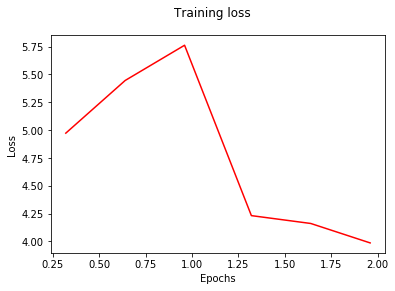

In [135]:
print_loss(work_dir)

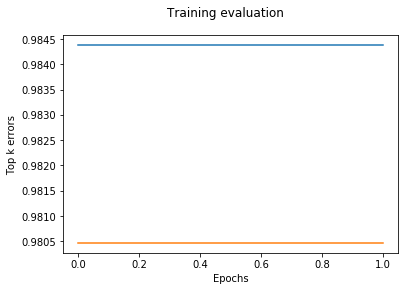

In [136]:
print_eval(work_dir)

### Perform multi-threaded workflow -- train and plot

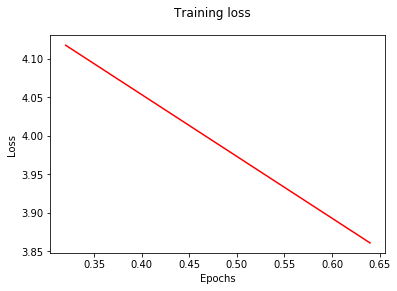

In [150]:
import threading
import time

# Remove existing log and model
if os.path.isfile(work_dir + '/train_log.pkl'):
    os.remove(work_dir + '/train_log.pkl')
if os.path.isfile(work_dir + '/best_model_state_dict.pt'):
    os.remove(work_dir + '/best_model_state_dict.pt')

try:
    stop_threads = False
    workers = []
    #
    thread_training = threading.Thread(target=train_model, \
                                       args=(work_dir, model, device, train_dataloader, \
                                             loss_func, optimizer, \
                                             lr_scheduler, \
                                             num_epochs, \
                                             evaluater, 1, False, \
                                             lambda: stop_threads))
    thread_plotting = threading.Thread(target=print_loss, \
                                       args=(work_dir, 3, \
                                             lambda: stop_threads or not thread_training.is_alive()))
    thread_training.start()
    thread_plotting.start()
    #
    workers.append(thread_training)
    workers.append(thread_plotting)
    #
    #time.sleep(100)
    #print('main: done sleeping; time to stop the threads.')
    #stop_threads = True
    #for worker in workers:
    #    worker.join()
    #print('Finis.')
except KeyboardInterrupt:
    stop_threads = True
    for worker in workers:
        worker.join()
    print('Training interrupted.')

In [152]:
#
#  Stop the threads
stop_threads = True
print('Still running for some seconds')
while thread_training.is_alive() or thread_plotting.is_alive():
    continue
    
print('Training interrupted')
print(thread_training.is_alive())
print(thread_plotting.is_alive())

Still running for some seconds
Training interrupted
False
False


In [143]:
print(thread_training.is_alive())
print(thread_plotting.is_alive())

False
False


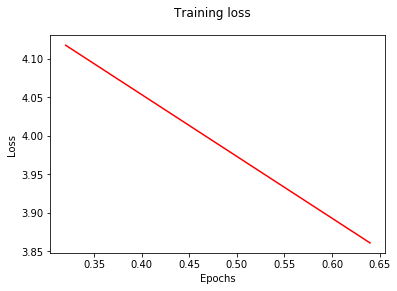

In [153]:
print_loss(work_dir)

In [344]:
thread1.is_alive()

False

In [340]:
import threading
import time

exitFlag = 0

class myThread (threading.Thread):
   def __init__(self, threadID, name, counter):
      threading.Thread.__init__(self)
      self.threadID = threadID
      self.name = name
      self.counter = counter
   def run(self):
      print("Starting " + self.name)
      print_time(self.name, 5, self.counter)
      print("Exiting " + self.name)

def print_time(threadName, counter, delay):
   while counter:
      if exitFlag:
         threadName.exit()
      time.sleep(delay)
      print("%s: %s" % (threadName, time.ctime(time.time())))
      counter -= 1

# Create new threads
thread1 = myThread(1, "Thread-1", 1)
#thread2 = myThread(2, "Thread-2", 2)

# Start new Threads
thread1.start()
#thread2.start()

print("Exiting Main Thread")

Starting Thread-1
Exiting Main Thread


In [342]:
thread1.run()

Starting Thread-1
Thread-1: Tue Nov 30 15:43:14 2021
Thread-1: Tue Nov 30 15:43:15 2021
Thread-1: Tue Nov 30 15:43:16 2021
Thread-1: Tue Nov 30 15:43:17 2021
Thread-1: Tue Nov 30 15:43:18 2021
Exiting Thread-1


In [300]:
import multiprocessing as mp

In [301]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.